In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

from IPython import display
import time
import itertools

from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

<IPython.core.display.Javascript object>


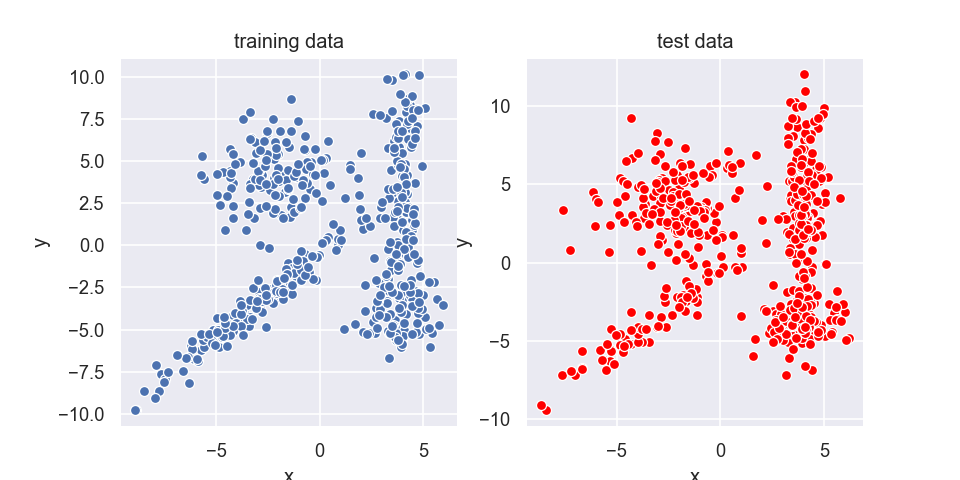

In [3]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('training data')
sns.scatterplot(x="x", y="y", data=data_train)
plt.subplot(122)
plt.title('test data')
sns.scatterplot(x="x", y="y", data=data_test, color='red');

# K-means

In [4]:
def Jfunc(X, mu, z, k):
    J = 0
    for i in range(k):
         J += np.sum(np.power(np.linalg.norm(X[z==i] - mu[i,:], axis=1), 2))
    return J

In [5]:
def kmeans(X, k, eps, display='all', timing=0.4):
    
    # initialization
    mu = X[np.random.randint(0, X.shape[0],k), :]
    convergence = False
    
    if display=='all':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        palette = ['red', 'blue', 'green', 'purple', 'yellow', 'orange']
        plt.ion()
        ax.clear()
        ax.scatter(x=X[:, 0], y=X[:, 1], c='red')
        ax.scatter(x=mu[:, 0], y=mu[:, 1], c='black', marker='X')
        fig.canvas.draw()  # draw
        time.sleep(timing)  #sleep
        fig.show();
        
    j = np.inf

    while not(convergence):
        # optimize over z
        z = np.argmin(distance_matrix(X, mu), axis=1)
        
        if display=='all':
            ax.clear()  # clear
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=z, palette=palette)
            fig.canvas.draw()  # draw
            time.sleep(timing)  #sleep
        
        #optimize over mu
        for i in range(0,k):
            mu[i, :] = X[z==i].mean(axis=0)
            
        if display == 'all':
            ax.scatter(x=mu[:, 0], y=mu[:, 1], c='black', marker='X')
            fig.canvas.draw()  # draw
            time.sleep(timing) 
            
        #convergence evaluation
        if np.abs(j - Jfunc(X, mu, z, k))<eps:
            convergence = True
        else:
            j = Jfunc(X, mu, z, k)
        
        if display == 'all':
            fig.canvas.set_window_title('J: {}'.format(j))
    
    return mu, z

<IPython.core.display.Javascript object>


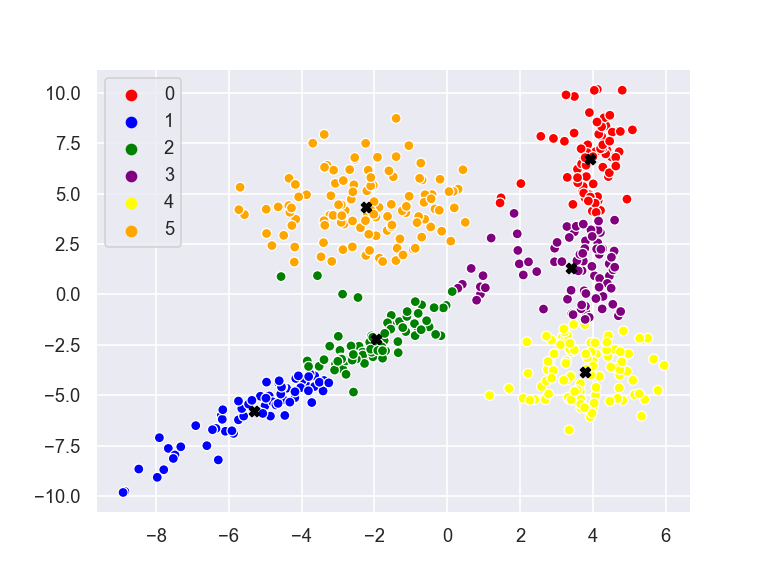

In [6]:
mu, z = kmeans(data_train.values, 6, 0.1, display='all', timing=0.2)

### Experiments with several random initializations

In [7]:
# compute a transportation distance between two point clouds with the same number of points
def transport_distance(mu1, mu2):
    dist = np.inf
    n_points = mu1.shape[0]
    
    for permutation in itertools.permutations(list(range(n_points))):
        dist = min(dist, np.sum((mu1 - mu2[np.array(permutation)]) ** 2))
        
    return dist

In [8]:
n_runs = 10
K = 4
mu_tab = []
J_tab = []

for _ in range(n_runs):
    mu, z = kmeans(data_train.values, K, 0.1, display=None)
    mu_tab.append(mu)
    J_tab.append(Jfunc(data_train.values, mu, z, K))

max_transport_dist = 0
for i in range(n_runs):
    for j in range(n_runs):
        transport_dist = transport_distance(mu_tab[i], mu_tab[j])
        max_transport_dist = max(max_transport_dist, transport_dist)

print('{} clusters'.format(K))
print('Mean distortion: {:.0f}  standard deviation: {:.2f}'.format(np.mean(J_tab), np.std(J_tab)))
print('Maximum transportation distance between centers: {:.2f}'.format(max_transport_dist))

4 clusters
Mean distortion: 3239  standard deviation: 1.44
Maximum transportation distance between centers: 0.23


In [9]:
n_runs = 10
K = 6
mu_tab = []
J_tab = []

for _ in range(n_runs):
    mu, z = kmeans(data_train.values, K, 0.1, display=None)
    mu_tab.append(mu)
    J_tab.append(Jfunc(data_train.values, mu, z, K))

max_transport_dist = 0
for i in range(n_runs):
    for j in range(n_runs):
        transport_dist = transport_distance(mu_tab[i], mu_tab[j])
        max_transport_dist = max(max_transport_dist, transport_dist)

print('{} clusters'.format(K))
print('Mean distortion: {:.0f}  standard deviation: {:.2f}'.format(np.mean(J_tab), np.std(J_tab)))
print('Maximum transportation distance between centers: {:.2f}'.format(max_transport_dist))

6 clusters
Mean distortion: 1984  standard deviation: 256.83
Maximum transportation distance between centers: 79.98


# Gaussian mixtures

In [10]:
cmaps_dict = {'blue':'Blues',
              'red':'Reds',
              'green':'Greens',
              'purple':'Purples',
              'grey': 'Greys',
              'orange':'Oranges'}

palette = ['red', 'blue', 'green', 'purple', 'grey', 'orange']

In [11]:
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """
    Create a grid in the form of a list of points stored in a 2D array
    """

    if data is not None:
        xmax, xmin,  = np.max(data[:, 0]), np.min(data[:, 0])
        ymax, ymin = np.max(data[:, 1]), np.min(data[:, 1])
        
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1./step), 
                       np.arange(ymin, ymax, (ymax-ymin)*1./step))
    
    grid = np.c_[x.ravel(), y.ravel()]

    return grid, x, y

In [12]:
class GaussianMixture():
    
    def __init__(self, X, k, covariance_mode, eps=0.1, n_itermax=100, display='all', timing=0.1):
        
        # input parameters
        self.X = X
        self.k = k
        self.covariance_mode = covariance_mode
        self.eps = eps  # convergence threshold
        self.n_itermax = n_itermax 
        
        
        # kmeans initialization
        mu, tau = kmeans(X, k, 0.1, display=None)
        self.tau = pd.get_dummies(tau).values.astype(float)
        
        # Gaussians mean and covariance matrix initialization
        self.mus = np.zeros((self.X.shape[1], k))
        if covariance_mode == 'isotrope':
            self.sigmas = np.zeros(k)
        else:
            self.sigmas = np.zeros((k, self.X.shape[1], self.X.shape[1]))
        
        # compute mean and covariance knowing tau
        self.m_step()
        # display settings
        if display=='all':
            self.timing = timing
            self.set_display()
            self.display()
        
    def set_display(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        if self.covariance_mode == 'isotrope':  # allow to visualize isotropy
            self.ax.axis('scaled')
        self.palette =  np.random.permutation(palette)[:self.k].tolist()
        plt.ion()

        # grid used to display ellipses containing a certain percentage
        # of the mass of the Gaussian distribution
        grid, x_grid, y_grid = make_grid(data=self.X, step=100)
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.grid = grid
        self.ax.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
            
    def display(self):
        self.ax.clear()
        for j in range(self.k):
            self.ax.contour(self.x_grid,
                            self.y_grid,
                            multivariate_normal.pdf(self.grid, 
                                                    mean=self.mus[:, j], 
                                                    cov=self.sigmas[j]).reshape(self.x_grid.shape),
                            levels = None,
                            alpha=0.6,
                            linestyles='solid',
                            cmap =cmaps_dict[self.palette[j]])

        sns.scatterplot(x=self.X[:, 0], y=self.X[:, 1], 
                        hue=np.argmax(self.tau, axis=1), palette=self.palette)
        
        self.ax.scatter(x=self.mus[0, :], y=self.mus[1, :], c='black', marker='X')
        
        self.fig.canvas.draw()  # draw
        time.sleep(self.timing)  # sleep
            
    def e_step(self):
        for j in range(self.k):
                self.tau[:, j] = self.pis[j] * multivariate_normal.pdf(self.X, 
                                                                       mean=self.mus[:, j], 
                                                                       cov=self.sigmas[j])
        self.tau = self.tau / self.tau.sum(axis=1).reshape(-1, 1)
        

    def m_step(self):
        self.pis = self.tau.mean(axis=0)
        for j in range(self.k):
            self.mus[:,j] = (self.X * (self.tau[:, j].reshape(-1, 1))).sum(axis=0) / self.tau[:,j].sum()
            
        if self.covariance_mode == 'isotrope':
            for j in range(self.k):
                X_centered_norm = np.power(np.linalg.norm(self.X - self.mus[:, j], axis=1),2)
                self.sigmas[j] = np.average(X_centered_norm, weights=self.tau[:, j])/2
        else:
            for j in range(self.k):
                X_centered = self.X - self.mus[:,j]
                sigma_i = (X_centered.T.dot(np.diag(self.tau[:, j]))).dot(X_centered)
                sigma_i = sigma_i / np.diag(self.tau[:, j]).sum()
                self.sigmas[j] = sigma_i
    
    def jfunc(self):
        res = 0
        for j in range(self.k):
            log_pdf = np.log(multivariate_normal.pdf(self.X, mean=self.mus[:, j], cov=self.sigmas[j]))
            res += (self.tau[:,j] * log_pdf).sum() + (self.tau[:,j] * np.log(self.pis[j])).sum()
        return res
    
    def fit(self):
        convergence = False
        n_iter = 0
        self.j = np.inf 
        while not(convergence):
            self.e_step()
            self.m_step()
            self.display()
            if (np.abs(self.j - self.jfunc()) < self.eps) or (n_iter > self.n_itermax):
                convergence = True
            else:
                self.j = self.jfunc()
                n_iter += 1

### Isotropic case

<IPython.core.display.Javascript object>


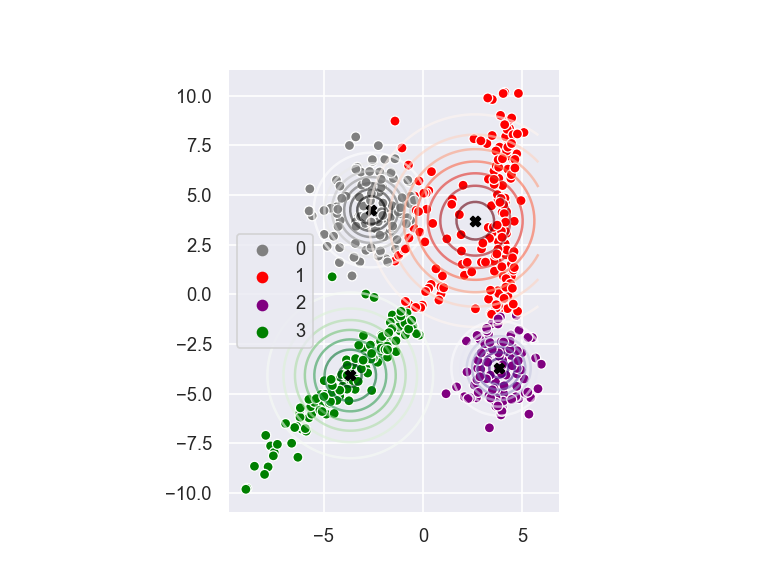

Log likelihood (training set): -2738.3060042198254
Log likelihood (test set): -7375.817306287856


In [13]:
g = GaussianMixture(data_train.values, 4, 'isotrope')
g.fit()
print('Log likelihood (training set): {}'.format(g.jfunc()))
g.X = data_test.values
print('Log likelihood (test set): {}'.format(g.jfunc()))

### General case

<IPython.core.display.Javascript object>


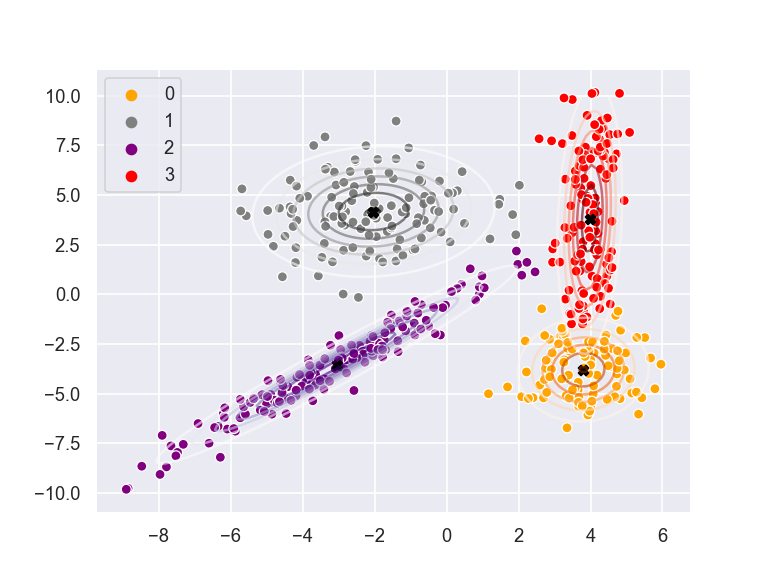

Log likelihood: -2370.361304448841
Log likelihood (test set): -18976.230711792996


In [14]:
g = GaussianMixture(data_train.values, 4, 'non-isotrope')
g.fit()
print('Log likelihood: {}'.format(g.jfunc()))
g.X = data_test.values
print('Log likelihood (test set): {}'.format(g.jfunc()))